In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import scipy.stats as stats
import pylab as pl

'''
filename
fifa_2018_results.csv
fifa_2018_results_updated_20180708.csv
fifa_2018_stats.csv
past_results.csv
players_scores.csv
sofifa.csv
'''

#Preparing data
data = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data.head()

data_home = data.groupby('home_team', as_index = False).agg({"home_result": np.sum})
data_away = data.groupby('away_team', as_index = False).agg({"away_result": np.sum})

data = data_home.rename( columns = {'home_team' : 'team'})
data['away_result'] = data_away['away_result']
data['total_score'] = data['away_result'] + data['home_result'] 

In [2]:
#Training Data
sofifa = pd.read_csv('dataset/sofifa1.csv') #only the latest stat
sofifa.rename(columns = {'countrystats' : 'team'} , inplace = True)
sofifa.head()

data_new = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data1 = data_new.join(sofifa.set_index('team'), on = 'home_team')
data1 = data1.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'away_team')

data1 = data1.drop(columns=['game','away_team','away_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data1 = data1.rename( columns = {'home_team': 'team','home_result' : 'result'})

data2 = data_new.join(sofifa.set_index('team'), on = 'away_team')
data2 = data2.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'home_team')

data2 = data2.drop(columns=['game','home_team','home_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data2 = data2.rename( columns = {'away_team': 'team','away_result' : 'result'})

pd.options.display.max_rows = 200
data_new = data1.append(data2 , ignore_index = True)
data_new = data_new.dropna()
#data_new

# split train and test
y = data_new['result']
X = data_new.drop(columns = ['date','team','result'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#Prediction Data
fr = sofifa[sofifa['team'] == 'France'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)
cr = sofifa[sofifa['team'] == 'Croatia'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)

data_predict = fr.join( cr.drop(columns = 'team').add_suffix('_opponent'))
data_predict = data_predict.append(cr.join(fr.drop(columns = 'team').add_suffix('_opponent')), ignore_index = True)
team = data_predict['team']
data_predict.drop(columns ='team', inplace = True)
data_predict

(64, 24) (64,)
(8, 24) (8,)


,overall,attack,midfield,defense,bu_speed,bu_passing,cc_crossing,cc_passing,cc_shooting,aggression,...,midfield_opponent,defense_opponent,bu_speed_opponent,bu_passing_opponent,cc_crossing_opponent,cc_passing_opponent,cc_shooting_opponent,aggression_opponent,pressure_opponent,avg_age_opponent
0,84,83,85,82,35,30,53,24,35,47,...,78,74,59,44,74,39,61,61,61,26.64
1,78,78,78,74,59,44,74,39,61,61,...,85,82,35,30,53,24,35,47,47,25.65


In [3]:
team = np.array(data['team'])
home_s = np.array(data['home_result'])
away_s = np.array(data['away_result'])
total_s = np.array(data['total_score'])

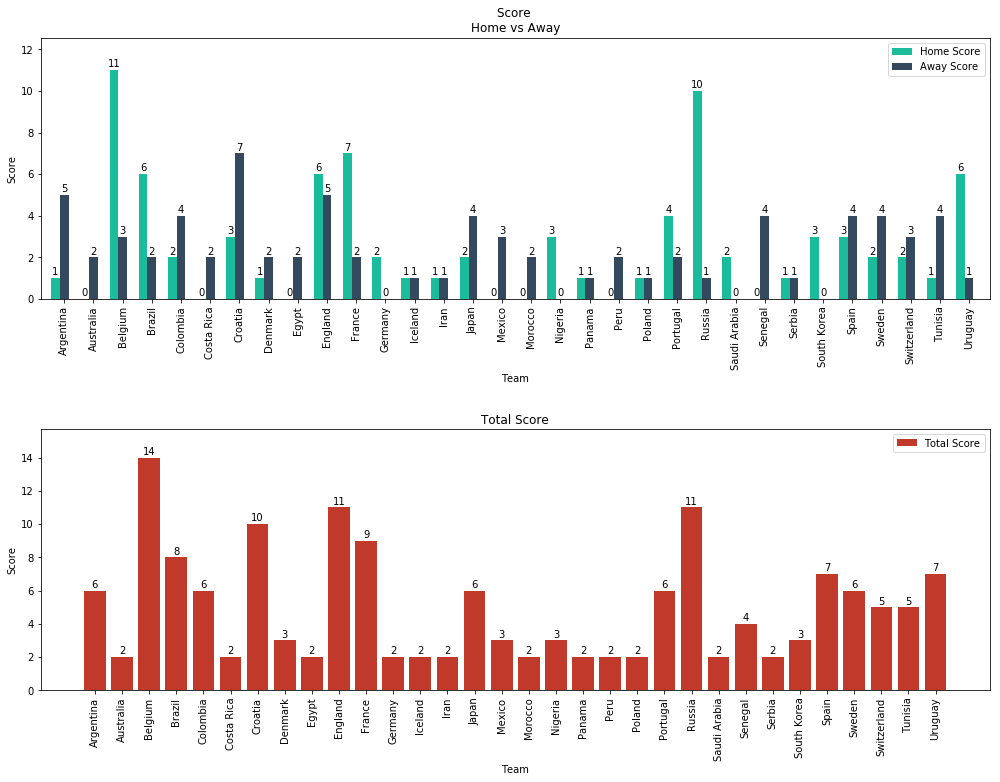

In [4]:
data['team'] = data['team'].astype('category')
index = data['team'].cat.codes
width = 0.3

fig , (ax ,axt) = plt.subplots(2, figsize=(17,12))
fig.subplots_adjust(hspace=.5)

home = ax.bar(index, home_s, width, label = 'Home Score', color = '#1abc9c')
away = ax.bar(index +width, away_s, width, label = 'Away Score', color ='#34495e')


def autolabel(bar):
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
ax.set_xlim(left = min(index)-0.5 , right = max(index) + 1 )
ax.set_ylim(top = ax.get_ylim()[1] + 1)
ax.set_xticks(index + width) 
ax.set_xticklabels(team,  rotation='vertical')
ax.set_title('Score \nHome vs Away')
ax.set_xlabel('Team')
ax.set_ylabel('Score')
ax.legend()

autolabel(away)
autolabel(home)


total = axt.bar(data['team'], data['total_score'], label = 'Total Score' , color = '#c0392b')
axt.set_ylim(top = axt.get_ylim()[1] + 1)
axt.set_xticks(data['team']) 
axt.set_xticklabels(data['team'],  rotation='vertical')
axt.set_title('Total Score')
axt.set_xlabel('Team')
axt.set_ylabel('Score')
axt.legend()

for b in total:
    height = b.get_height()
    axt.text(b.get_x() +b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
plt.show()

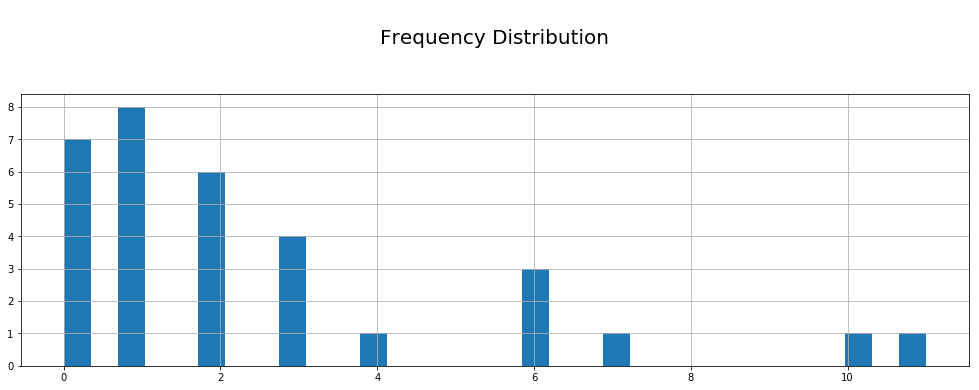

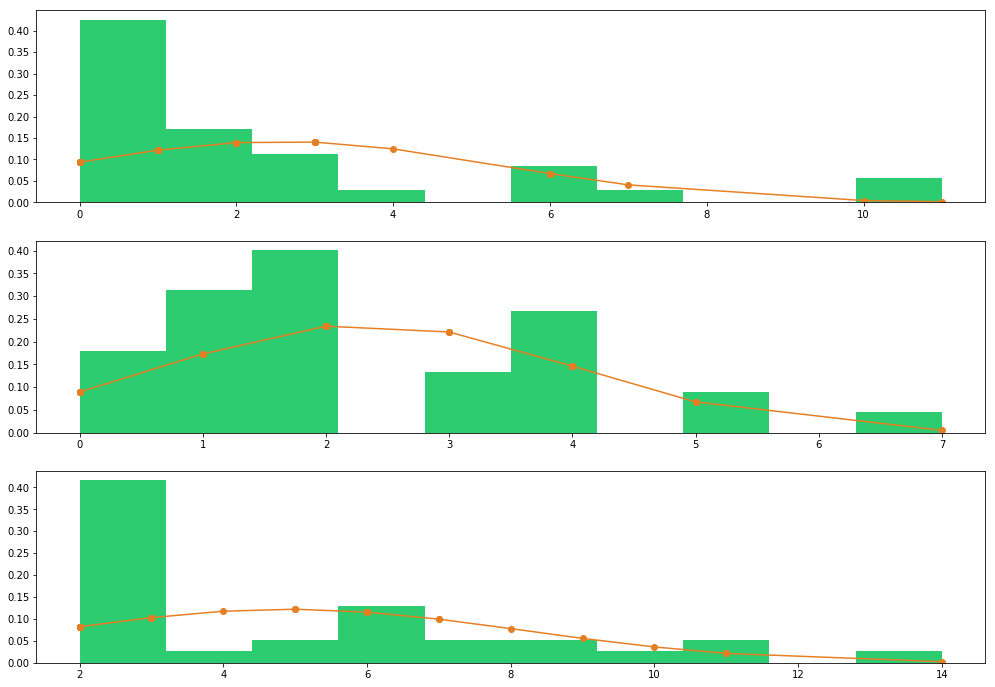

In [48]:
#Frequency Distribution 
sorted_home = np.sort(home_s)
sorted_away = np.sort(away_s)
sorted_total = np.sort(total_s)

plt.figure(figsize=(17,5))
plt.hist(sorted_home, bins = home_s.size)
plt.title('\nFrequency Distribution\n\n', fontsize= 20)
plt.grid(True)
plt.show()

fig , (fq1,fq2,fq3) = plt.subplots(3, figsize=(17,12))

def freq_dist(fq,dat):    
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat)) 
    fq.plot(dat,fit,'-o' , color = '#e67e22')
    fq.hist(dat, density=True , color = '#2ecc71')
     
freq_dist(fq1,sorted_home)
freq_dist(fq2,sorted_away)
freq_dist(fq3,sorted_total)

plt.show() 

In [6]:
#Descriptive Analysis

#Mean | not skewed
home_mean = home_s.sum()/ home_s.size
away_mean = away_s.sum()/ away_s.size
total_mean = total_s.sum()/ total_s.size
print('Mean')
print(' Home : ' + str(home_mean))
print(' Away : ' + str(away_mean))
print(' Total : ' + str(total_mean))

#Median| skewed

#Mode
#Best measure of central tendency (nominal)
print('Mode')
print(' Home : ' + str(np.nanmax(home_s)))
print(' Away : ' + str(np.nanmax(away_s)))
print(' Total : ' + str(np.nanmax(total_s)))

Mean
 Home : 2.5625
 Away : 2.34375
 Total : 4.90625
Mode
 Home : 11
 Away : 7
 Total : 14


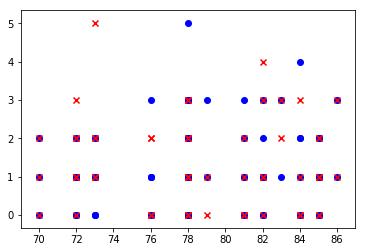

In [7]:
#Analyze Data Condition for model selection
result = np.array( data_new['result'])
overall = np.array(data_new['overall'])
overall_op = np.array(data_new['overall_opponent'])

for i in range (0,result.size):
    plt.scatter(overall[i],result[i], marker ='o', c ='b')

for i in range (0,result.size):
    plt.scatter(overall_op[i],result[i] , marker = 'x', c= 'r')
    
plt.show()



In [8]:
#Feature Extraction
from sklearn.decomposition import PCA, KernelPCA

def PCA_Transformer(PCA_data):    
    PCA_data = np.array(PCA_data)
    pca =PCA(n_components =24)
    pca.fit(PCA_data)
    #pca.fit_transform(PCA_data)
    X = pca.transform(PCA_data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)  
    print(X.size)
    
    return X


In [9]:
PCA_Transformer(X_train)

[2.53796525e-01 2.39304785e-01 1.23673206e-01 8.22059975e-02
 6.11289442e-02 5.79823806e-02 4.00134956e-02 3.29858730e-02
 3.06758087e-02 2.57681486e-02 2.06927353e-02 1.51414709e-02
 4.23604035e-03 3.93733382e-03 2.82591341e-03 1.83509727e-03
 1.24680382e-03 1.14302536e-03 4.93784866e-04 4.46201954e-04
 2.34670825e-04 1.41196164e-04 4.81250667e-05 4.24360290e-05]
[194.64889349 189.01000558 135.87730165 110.77987099  95.52841033
  93.03730556  77.28804995  70.17349297  67.67170417  62.02270614
  55.57993756  47.54371743  25.14717174  24.24433198  20.5394367
  16.55154913  13.64294617  13.06282281   8.58574511   8.16159119
   5.91886798   4.59114018   2.68037017   2.51696092]
1536


array([[  1.17630614,  24.64496098, -19.20087295, ...,  -0.68295218,
         -0.36806212,   0.0949964 ],
       [ 50.80843594,  -4.43418539, -15.78144092, ...,   0.34847275,
          0.47824031,  -0.20826219],
       [  0.90211755,   8.32184205, -30.35264105, ...,  -0.88642992,
          0.48853929,  -0.56346087],
       ...,
       [ 48.38394741, -24.08575543,  12.75916945, ...,  -1.00662798,
          0.13347485,   0.46262869],
       [ 30.36189375, -18.41305374,  22.28659759, ...,  -0.15250155,
          0.2532157 ,   0.2026791 ],
       [ 16.09316372,   0.94599723,   8.56504821, ...,  -0.59420535,
         -0.0785064 ,   0.07501283]])

In [10]:
#Modelling
from sklearn.neural_network import MLPClassifier

clf1 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                   early_stopping=False, hidden_layer_sizes=(18, 2), learning_rate='constant',
                   learning_rate_init=0.001, max_iter=5000, random_state=1, shuffle=True,
                   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
                   warm_start=False)
clf1.fit(X_train, y_train)

clf2 =  MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                     beta_1=0.9, beta_2=0.999, early_stopping=False,
                     epsilon=1e-08, hidden_layer_sizes=(18, 2), learning_rate='constant',
                     learning_rate_init=0.001, max_iter=5000,random_state=1, shuffle=True,
                     solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
                     warm_start=False)

clf2.fit(X_train, y_train)

clf3 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       early_stopping=False,hidden_layer_sizes=(18, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

clf3.fit(X_train, y_train)

Iteration 1, loss = 10.31259130
Iteration 2, loss = 10.09669522
Iteration 3, loss = 9.93644801
Iteration 4, loss = 9.80617275
Iteration 5, loss = 9.69415972
Iteration 6, loss = 9.57414914
Iteration 7, loss = 9.47355332
Iteration 8, loss = 9.38413273
Iteration 9, loss = 9.30411933
Iteration 10, loss = 9.23271142
Iteration 11, loss = 9.17005460
Iteration 12, loss = 9.05532960
Iteration 13, loss = 8.81798062
Iteration 14, loss = 8.27358975
Iteration 15, loss = 7.34221859
Iteration 16, loss = 6.09899070
Iteration 17, loss = 4.89220600
Iteration 18, loss = 3.81980867
Iteration 19, loss = 3.02691620
Iteration 20, loss = 2.53536023
Iteration 21, loss = 2.29384858
Iteration 22, loss = 2.17350315
Iteration 23, loss = 2.08342919
Iteration 24, loss = 2.04347964
Iteration 25, loss = 2.01744918
Iteration 26, loss = 2.00509835
Iteration 27, loss = 1.99616773
Iteration 28, loss = 1.99212261
Iteration 29, loss = 1.99266942
Iteration 30, loss = 1.99292807
Iteration 31, loss = 1.99202860
Training loss d

Iteration 337, loss = 1.65628920
Iteration 338, loss = 1.65571516
Iteration 339, loss = 1.65514305
Iteration 340, loss = 1.65457288
Iteration 341, loss = 1.65400463
Iteration 342, loss = 1.65343830
Iteration 343, loss = 1.65287389
Iteration 344, loss = 1.65231138
Iteration 345, loss = 1.65175076
Iteration 346, loss = 1.65119204
Iteration 347, loss = 1.65063520
Iteration 348, loss = 1.65008024
Iteration 349, loss = 1.64952714
Iteration 350, loss = 1.64897591
Iteration 351, loss = 1.64842652
Iteration 352, loss = 1.64787899
Iteration 353, loss = 1.64733329
Iteration 354, loss = 1.64678943
Iteration 355, loss = 1.64624740
Iteration 356, loss = 1.64570718
Iteration 357, loss = 1.64516877
Iteration 358, loss = 1.64463217
Iteration 359, loss = 1.64409737
Iteration 360, loss = 1.64356435
Iteration 361, loss = 1.64303312
Iteration 362, loss = 1.64250367
Iteration 363, loss = 1.64197599
Iteration 364, loss = 1.64145007
Iteration 365, loss = 1.64092591
Iteration 366, loss = 1.64040350
Iteration 

Iteration 710, loss = 1.53082852
Iteration 711, loss = 1.53064375
Iteration 712, loss = 1.53045946
Iteration 713, loss = 1.53027567
Iteration 714, loss = 1.53009236
Iteration 715, loss = 1.52990954
Iteration 716, loss = 1.52972720
Iteration 717, loss = 1.52954535
Iteration 718, loss = 1.52936398
Iteration 719, loss = 1.52918308
Iteration 720, loss = 1.52900267
Iteration 721, loss = 1.52882273
Iteration 722, loss = 1.52864326
Iteration 723, loss = 1.52846427
Iteration 724, loss = 1.52828575
Iteration 725, loss = 1.52810770
Iteration 726, loss = 1.52793012
Iteration 727, loss = 1.52775300
Iteration 728, loss = 1.52757635
Iteration 729, loss = 1.52740016
Iteration 730, loss = 1.52722444
Iteration 731, loss = 1.52704917
Iteration 732, loss = 1.52687436
Iteration 733, loss = 1.52670001
Iteration 734, loss = 1.52652612
Iteration 735, loss = 1.52635268
Iteration 736, loss = 1.52617969
Iteration 737, loss = 1.52600716
Iteration 738, loss = 1.52583507
Iteration 739, loss = 1.52566343
Iteration 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(18, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [17]:
#Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)
score1 = clf1.predict(data_predict)
#Adam
score2 = clf2.predict(data_predict)
#Stochastic Gradient Descent
score3 = clf3.predict(data_predict)

print('\tFrance\tCroatia')
print('Adam\t   ' + str(score1[0])+ '\t   '+ str(score1[1]))
print('LBFGS\t   '+ str(score2[0])+ '\t   '+ str(score2[1]))
print('SGD\t   '+ str(score3[0])+ '\t   '+ str(score3[1]))

	France	Croatia
Adam	   1	   1
LBFGS	   4	   4
SGD	   1	   1


In [28]:
#Confusion matrix
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred3 = clf3.predict(X_test)

total = y_test.size
cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
cm3 = confusion_matrix(y_test, y_pred3)
print(total)

#Accuracy
def cal_accuracy(cm):
    cm = np.array(cm)
    row,col = cm.shape
    TC =0
    for i in range (0,row):
        #TrueClassified
        TC += cm[i,i]
        
    return TC/total

#labels = range of goals/results
print('Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)')
print(cm1)
print('accuracy : '  + str(cal_accuracy(cm1)))
print('\n')

print('Adam')
print(cm2)
print('accuracy : '  + str(cal_accuracy(cm2)))
print('\n')

print('Stochastic Gradient Descent')
print(cm3)
print('accuracy : '  + str(cal_accuracy(cm3)))
print('\n')

8
Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)
[[6 0 0]
 [1 0 0]
 [1 0 0]]
accuracy : 0.75


Adam
[[0 0 0 6]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]
accuracy : 0.0


Stochastic Gradient Descent
[[6 0 0]
 [1 0 0]
 [1 0 0]]
accuracy : 0.75


